# Machine Learning Application in predicting price of used cars


### In this part, I will use prepared data from the first part (used_cars_EDA) as an input for several machine learning algorithms. 

In [49]:
## Import necessary library
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Datasets downloaded from https://www.kaggle.com/austinreese/craigslist-carstrucks-data


In [3]:
ytest = np.load("y_test.npz")
ytrain = np.load("y_train.npz")
Xtrain_pca = np.load("X_train.npz")
Xtest_pca = np.load("X_test.npz")


In [4]:
X_test_pca = Xtest_pca.f.arr_0
X_train_pca = Xtrain_pca.f.arr_0
y_test = ytest.f.arr_0
y_train = ytrain.f.arr_0


# *Machine Learning Models*

### First let's start with a simple Linear Rigression to see how it works.

## 1. Baseline Model: Linear Regression

In [16]:
%%time
lr = LinearRegression()
lr.fit(X_train_pca, y_train)
print("R2 score:", round(lr.score(X_test_pca, y_test), 2))
print("RMSE", np.sqrt(mean_squared_error(y_test, lr.predict(X_test_pca))))


R2 score: 0.79
RMSE 0.3580994950228594
CPU times: user 8.62 s, sys: 514 ms, total: 9.13 s
Wall time: 1.18 s


### Even after PCA dimensionality reduction, our input data size require longer time to train with several machine learning models. Hence, I will first use a subset of the input data for hyperparameter tuning (finding optimum parameter). 

In [19]:
X_train_sub = X_train_pca[0:10000]
X_test_sub = X_test_pca[0:10000]
y_train_sub = y_train[0:10000]
y_test_sub = y_test[0:10000]


## 2. Decision Tree Regression:

In [32]:
%%time
DTr = DecisionTreeRegressor(max_depth=6)
DTr.fit(X_train_sub, y_train_sub)
print("R2 score:", DTr.score(X_test_sub, y_test_sub))
print("RMSE", np.sqrt(mean_squared_error(y_test_sub, DTr.predict(X_test_sub))))


R2 score: 0.6988037243851297
RMSE 0.43303229382357805
CPU times: user 1.02 s, sys: 4.66 ms, total: 1.03 s
Wall time: 1.03 s


In [40]:
%%time
params = {"max_depth": range(2, 20, 2)}
DTr_GS = GridSearchCV(DTr, param_grid=params, n_jobs=-1)
DTr_GS.fit(X_train_pca, y_train)


CPU times: user 49.3 s, sys: 562 ms, total: 49.9 s
Wall time: 2min 52s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=15,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=4,
                                             min_samples_split=5,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1, param_grid={'max_depth': range(2, 20, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
print("Best parameters:", DTr_GS.best_params_)
print("Best score:", DTr_GS.best_score_)


Best parameters: {'max_depth': 16}
Best score: 0.8085053290751634


In [42]:
%%time
DTr = DecisionTreeRegressor(max_depth=16)
DTr.fit(X_train_pca, y_train)
print("R2 score:", DTr.score(X_test_pca, y_test))
print("RMSE", np.sqrt(mean_squared_error(y_test, DTr.predict(X_test_pca))))


R2 score: 0.8177404449705394
RMSE 0.3353178298546902
CPU times: user 47.7 s, sys: 199 ms, total: 47.9 s
Wall time: 48.1 s


## 3. Support Vector Regressor

In [43]:
%%time
svr = SVR()
svr.fit(X_train_sub, y_train_sub)
print("R2 score:", svr.score(X_test_sub, y_test_sub))
print("RMSE", np.sqrt(mean_squared_error(y_test_sub, svr.predict(X_test_sub))))


/Users/rmainali/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


R2 score: 0.8028435897052105
Total model train time: 0.8089230060577393
RMSE 0.3503490449260718
CPU times: user 55 s, sys: 163 ms, total: 55.2 s
Wall time: 53.9 s


In [45]:
params = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf"],
}
svr_GS = GridSearchCV(SVR(), param_grid=params, n_jobs=-1)
svr_GS.fit(X_train_sub, y_train_sub)


/Users/rmainali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [46]:
print("Best parameters:", svr_GS.best_params_)
print("Best score:", svr_GS.best_score_)


Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.8613609338868699


In [48]:
%%time
svr = SVR(C=1, gamma=0.1, kernel="rbf")
svr.fit(X_train_sub, y_train_sub)
print("R2 score:", svr.score(X_test_sub, y_test_sub))
print("RMSE", np.sqrt(mean_squared_error(y_test_sub, svr.predict(X_test_sub))))


R2 score: 0.8712674137392618
RMSE 0.28309991177534777
CPU times: user 49.8 s, sys: 145 ms, total: 50 s
Wall time: 50 s


In [81]:
%%time
svr = SVR(C=1, gamma=0.1, kernel="rbf")
svr.fit(X_train_pca, y_train)
print("R2 score:", svr.score(X_test_pca, y_test))
print("RMSE", np.sqrt(mean_squared_error(y_test, svr.predict(X_test_pca))))


R2 score: 0.9045915188684079
RMSE 0.2426079259131824
CPU times: user 9h 34min 35s, sys: 22.3 s, total: 9h 34min 58s
Wall time: 9h 35min 25s


## 4. K Neighbors Regression:

Let's first find best k value for K Neighbors regression using the smaller dataset.

In [60]:
rmse_knr = []
for k in range(2, 30, 3):
    KNr = KNeighborsRegressor(n_neighbors=k)
    KNr.fit(X_train_sub, y_train_sub)
    test_scores = KNr.score(X_test_sub, y_test_sub)
    y_pred_knr = KNr.predict(X_test_sub)
    rmse_scores = np.sqrt(mean_squared_error(y_test_sub, y_pred_knr))
    rmse_knr.append(rmse_scores)


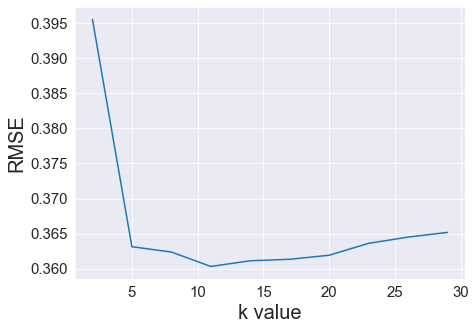

In [66]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(7, 5))
sc = sns.lineplot(x=range(2, 30, 3), y=rmse_knr, ax=ax)
sc.set_xlabel("k value", fontsize=20)
sc.set_ylabel("RMSE", fontsize=20)
sc.tick_params(labelsize=15)


The minimum RMSE is found at k value of 12. So, we will use that k value to train the whole dataset.

In [67]:
KNr = KNeighborsRegressor(n_neighbors=12)
KNr.fit(X_train_pca, y_train)
test_scores = KNr.score(X_test_pca, y_test)
y_pred_knr = KNr.predict(X_test_pca)
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred_knr))


In [69]:
print(round(test_scores,2),round(rmse_scores,2))

0.86 0.29


## 5. Random Forest Regression: 

In [50]:
%%time
rfr = RandomForestRegressor(max_depth=15, n_estimators=150, n_jobs=-1)
rfr.fit(X_train_sub, y_train_sub)
print("R2 score:", rfr.score(X_test_sub, y_test_sub))


R2 score: 0.8248192792727722
CPU times: user 5min 45s, sys: 715 ms, total: 5min 45s
Wall time: 23.3 s


In [51]:
params = {"max_depth": [10, 15, 20, 25], "n_estimators": [100, 150, 200, 250]}
rfr_GS = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1)
rfr_GS.fit(X_train_sub, y_train_sub)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25

In [52]:
print("Best parameters:", rfr_GS.best_params_)
print("Best score:", rfr_GS.best_score_)


Best parameters: {'max_depth': 25, 'n_estimators': 200}
Best score: 0.8099638488522174


In [53]:
%%time
rfr = RandomForestRegressor(max_depth=25, n_estimators=200, n_jobs=-1)
rfr.fit(X_train_sub, y_train_sub)
print("R2 score:", rfr.score(X_test_sub, y_test_sub))


R2 score: 0.8269584471189603
CPU times: user 9min 27s, sys: 2.31 s, total: 9min 29s
Wall time: 40.8 s


In [54]:
%%time
rfr = RandomForestRegressor(max_depth=25, n_estimators=200, n_jobs=-1)
rfr.fit(X_train_pca, y_train)
print("R2 score:", rfr.score(X_test_pca, y_test))


R2 score: 0.9078559497781141
CPU times: user 5h 49min 17s, sys: 41.1 s, total: 5h 49min 58s
Wall time: 23min 8s


In [86]:
print("RMSE", np.sqrt(mean_squared_error(y_test, rfr.predict(X_test_pca))))


RMSE 0.23842135009664478


## 6. XGBoost Regression:

In [55]:
start_time = time.time()
xgb = XGBRegressor(learning_rate=0.1, max_depth=15, n_estimators=150, nthread=3)
xgb.fit(X_train_sub, y_train_sub)
run_time = time.time() - start_time
print("R2 score:", xgb.score(X_test_sub, y_test_sub))
print("Total model train time:", run_time)


[23:59:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score: 0.8547285808623788
Total model train time: 40.633137941360474


In [56]:
params = {
    "learning_rate": [0.05, 0.1, 0.15, 0.2],
    "max_depth": [10, 15, 20, 25, 30],
    "n_estimators": [100, 150, 200, 250],
}
xgb_GS = GridSearchCV(XGBRegressor(), param_grid=params, n_jobs=-1)
xgb_GS.fit(X_train_sub, y_train_sub)


[01:11:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [10, 15, 20, 25

In [57]:
print("Best parameters:", xgb_GS.best_params_)
print("Best score:", xgb_GS.best_score_)


Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 250}
Best score: 0.8467890801998949


In [58]:
start_time = time.time()
xgb = XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=250, nthread=3)
xgb.fit(X_train_pca, y_train)
run_time = time.time() - start_time
print("R2 score:", xgb.score(X_test_pca, y_test))
print("Total model train time:", run_time)


[01:16:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score: 0.9109334357561867
Total model train time: 939.1255948543549


In [87]:
print("RMSE", np.sqrt(mean_squared_error(y_test, xgb.predict(X_test_pca))))


RMSE 0.2344060646793416


In [327]:
def plot_residuals(Predicted_value, actual_value, title, col):
    sns.set_style(style="white")
    fig, ax = plt.subplots(figsize=(10, 6))
    residual = Predicted_value - actual_value
    sc = sns.scatterplot(Predicted_value, residual, color=str(col), ax=ax)
    sc.axes.set_title("Predicted vs actual car price (" + str(title) + ")", fontsize=20)
    sc.set_ylabel("Residual price", fontsize=20)
    sc.set_xlabel("Predicted price", fontsize=20)
    sc.tick_params(labelsize=15)
    return sc


In [ ]:
model = [lr, KNr, svr, DTr, rfr, xgb]
model_name = [
    "Linear Regression",
    "K Neighbors Regression",
    "Support Vector Regression",
    "Decision Tree Regression",
    "Random Forest Regression",
    "XGBoost Regression",
]
colors = ["blue", "green", "red", "orange", "brown", "purple"]
sns.set_style(style="whitegrid")
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
axs = axs.ravel()

for i in range(len(model)):
    sns.scatterplot(
        x=np.exp(y_test), y=np.exp(model[i].predict(X_test_pca)), ax=axs[i], s=30
    )
    axs[i].set_title(model_name[i])

fig.text(0.5, 0.04, "Actual Car Price", ha="center", va="center")
fig.text(
    0.06, 0.5, "Predicted Car Price", ha="center", va="center", rotation="vertical"
)
plt.savefig("predicted_price.png", dpi=300)


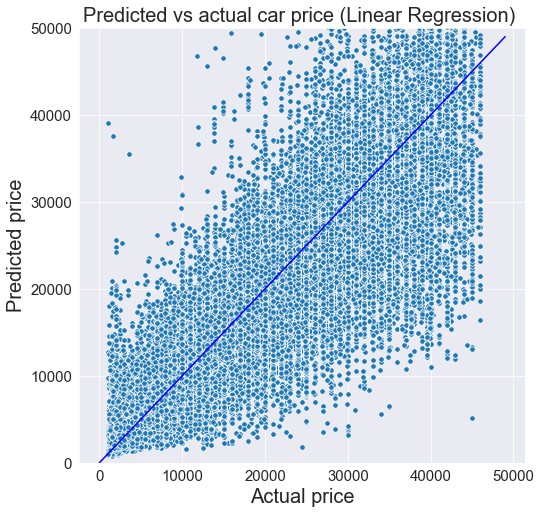

In [85]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 8))
sc = sns.scatterplot(x=np.exp(y_test), y=np.exp(lr.predict(X_test_pca)), ax=ax, s=30)
sns.lineplot(x=range(0, 50000, 1000), y=range(0, 50000, 1000), ax=ax, color="blue")
sc.axes.set_title("Predicted vs actual car price (Linear Regression) ", fontsize=20)
sc.set_xlabel("Actual price", fontsize=20)
sc.set_ylabel("Predicted price", fontsize=20)
sc.tick_params(labelsize=15)
ax.set_ylim(0, 50000)
plt.savefig("predicted_price_lr.png", dpi=300)


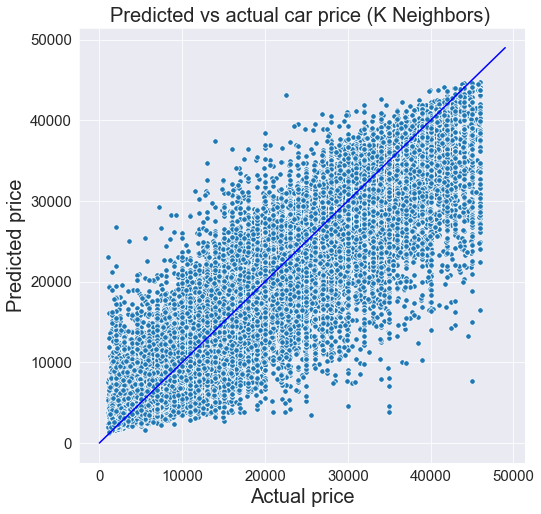

In [84]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 8))
sc = sns.scatterplot(x=np.exp(y_test), y=np.exp(KNr.predict(X_test_pca)), ax=ax, s=30)
sns.lineplot(x=range(0, 50000, 1000), y=range(0, 50000, 1000), ax=ax, color="blue")
sc.axes.set_title("Predicted vs actual car price (K Neighbors) ", fontsize=20)
sc.set_xlabel("Actual price", fontsize=20)
sc.set_ylabel("Predicted price", fontsize=20)
sc.tick_params(labelsize=15)
plt.savefig("predicted_price_knr.png", dpi=300)


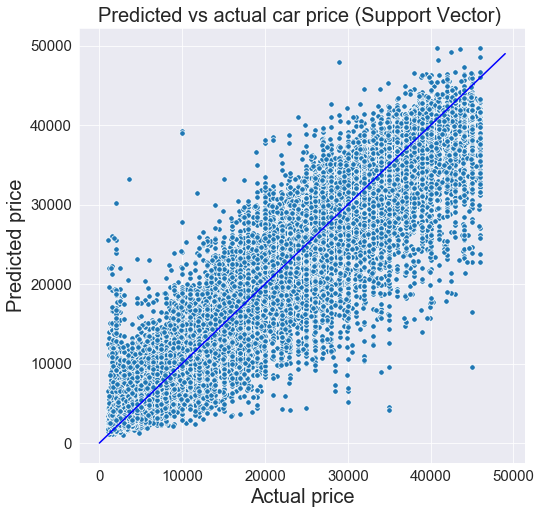

In [82]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 8))
sc = sns.scatterplot(x=np.exp(y_test), y=np.exp(svr.predict(X_test_pca)), ax=ax, s=30)
sns.lineplot(x=range(0, 50000, 1000), y=range(0, 50000, 1000), ax=ax, color="blue")
sc.axes.set_title("Predicted vs actual car price (Support Vector) ", fontsize=20)
sc.set_xlabel("Actual price", fontsize=20)
sc.set_ylabel("Predicted price", fontsize=20)
sc.tick_params(labelsize=15)
plt.savefig("predicted_price_svr.png", dpi=300)


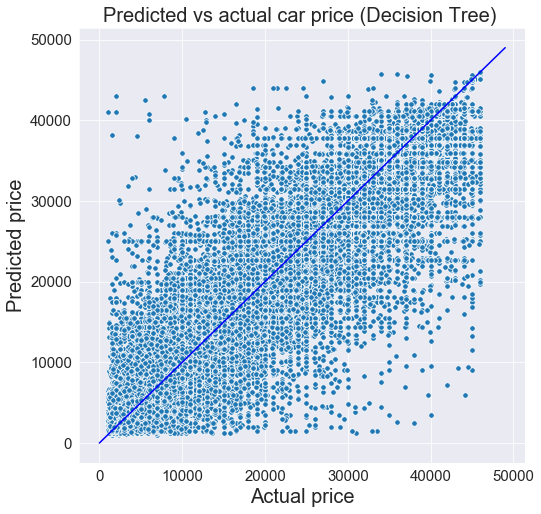

In [79]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 8))
sc = sns.scatterplot(x=np.exp(y_test), y=np.exp(DTr.predict(X_test_pca)), ax=ax, s=30)
sns.lineplot(x=range(0, 50000, 1000), y=range(0, 50000, 1000), ax=ax, color="blue")
sc.axes.set_title("Predicted vs actual car price (Decision Tree) ", fontsize=20)
sc.set_xlabel("Actual price", fontsize=20)
sc.set_ylabel("Predicted price", fontsize=20)
sc.tick_params(labelsize=15)
plt.savefig("predicted_price_dtr.png", dpi=300)


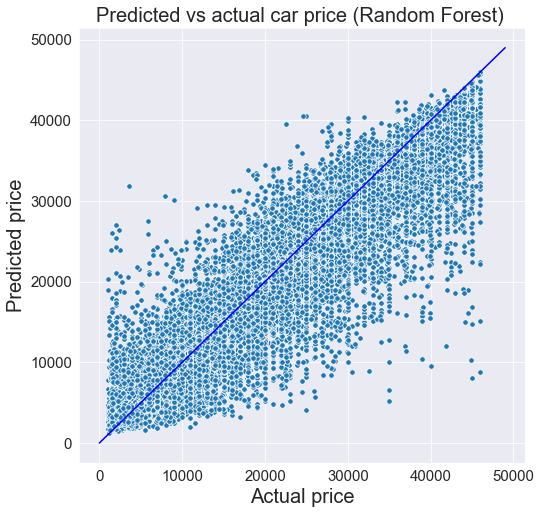

In [77]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 8))
sc = sns.scatterplot(x=np.exp(y_test), y=np.exp(rfr.predict(X_test_pca)), ax=ax, s=30)
sns.lineplot(x=range(0, 50000, 1000), y=range(0, 50000, 1000), ax=ax, color="blue")
sc.axes.set_title("Predicted vs actual car price (Random Forest) ", fontsize=20)
sc.set_xlabel("Actual price", fontsize=20)
sc.set_ylabel("Predicted price", fontsize=20)
sc.tick_params(labelsize=15)
plt.savefig("predicted_price_rfr.png", dpi=300)


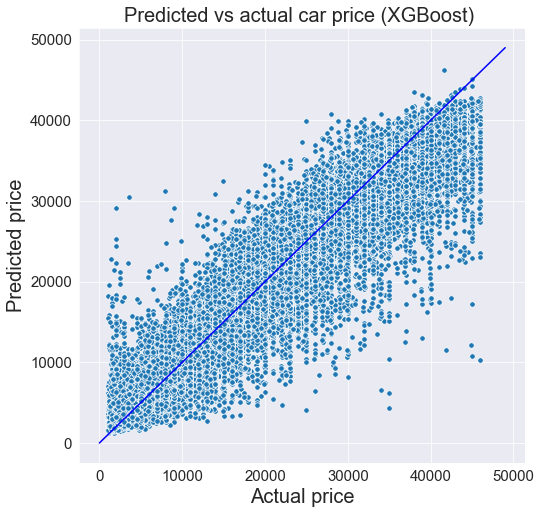

In [78]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 8))
sc = sns.scatterplot(x=np.exp(y_test), y=np.exp(xgb.predict(X_test_pca)), ax=ax, s=30)
sns.lineplot(x=range(0, 50000, 1000), y=range(0, 50000, 1000), ax=ax, color="blue")
sc.axes.set_title("Predicted vs actual car price (XGBoost) ", fontsize=20)
sc.set_xlabel("Actual price", fontsize=20)
sc.set_ylabel("Predicted price", fontsize=20)
sc.tick_params(labelsize=15)
plt.savefig("predicted_price_xgb.png", dpi=300)


## Which model performed better?
Let's check R-squared values and RMSE errors for different models.

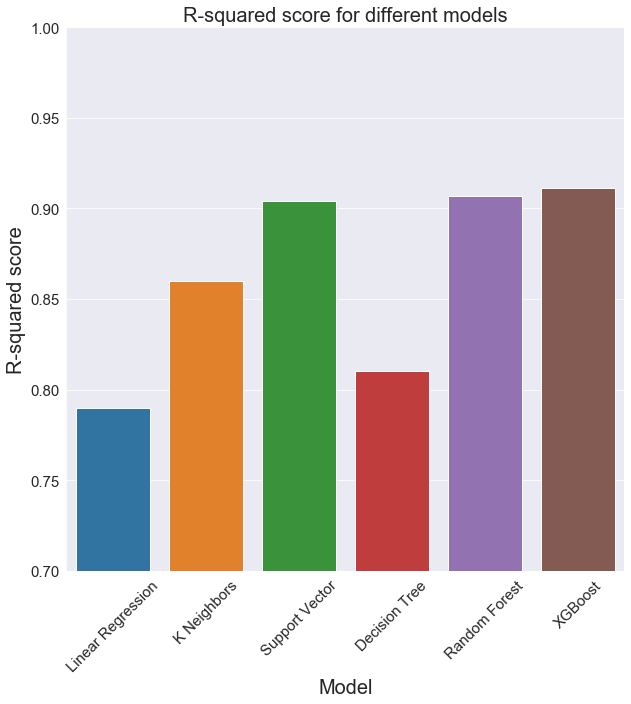

In [99]:
model_r2 = [0.79, 0.86, 0.904, 0.81, 0.907, 0.911]
model_name = [
    "Linear Regression",
    "K Neighbors",
    "Support Vector",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
]
model_rmse = [0.358, 0.29, 0.243, 0.335, 0.238, 0.238]

sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 10))
bar = sns.barplot(x=model_name, y=model_r2, ax=ax)
bar.axes.set_title("R-squared score for different models", fontsize=20)
plt.xticks(rotation=45)
bar.set_xlabel("Model", fontsize=20)
bar.set_ylabel("R-squared score", fontsize=20)
bar.tick_params(labelsize=15)
ax.set_ylim(0.7, 1.0)
plt.savefig("model_r2.png", dpi=300)


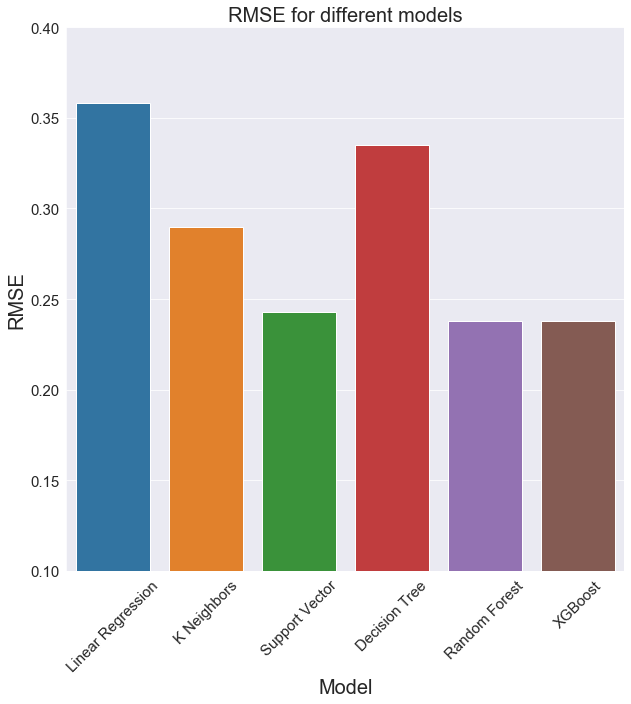

In [102]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 10))
bar = sns.barplot(x=model_name, y=model_rmse, ax=ax)
bar.axes.set_title("RMSE for different models", fontsize=20)
plt.xticks(rotation=45)
bar.set_xlabel("Model", fontsize=20)
bar.set_ylabel("RMSE", fontsize=20)
bar.tick_params(labelsize=15)
ax.set_ylim(0.1, 0.4)
plt.savefig("model_rmse.png", dpi=300)


#### As shown in both the R-squared and RMSE plots, XGBoost model performed slightly better than the other five models.

## Summary:

I considerd six different regression models to predict the car price. The baseline multiple linear regression model did a reasonable job achieving a R-squared value of close to 0.8. On top of that, the linear regression was very easy to run as well as executed in the least amount of time. Another traditional approach, K Neighbors regression even outperform the linear regression clocking a R-squared value of 0.86. But, it did require a fairly large time to run the model. The next model I considered, Support Vector Regression performed better than the first two model with a R-squared value of more than 0.87.

Then I considered three tree based models, i.e., Decision Tree Regression, Random Forest Regression and XGBoost regression. After fine tunning, Decision tree scored R-squared of only about 0.82 (lower than KNeighbors and SVR). Next, I fined tuned Random Forest Model to reach R-squared score of close to 0.9. Then, finally XGBoost model (after fine tunning) was able to score the best R-squared value of 0.91. However, the tree based models were quite time consuming to run. 

Overall, XGBoost model performed the best among all the models considered. There were still a large scattered in the predicted car values. One possible reason is that not all craigslist listing are legitimate. Often time, scammer post car ads with unrealistic price. This would introduce variance in the datasets. These days, some used car dealer are using cragslist to post ads to promote their business. Most of the time, they only post downpayment price for the  listed. In principle, these could be removed by performing natural language processing on the car listing descriptions. 

Finally, I think the model could be further improved by hypertunning parameters in the whole training set. This took much longer to process, so I had to rely on a small subset to identity best parameters. Provided computing resources, these models could be optimized to perform better.